In [1]:
import torch
import torch.nn as nn
import torchvision as tv
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# Hyperparameters
num_epoch = 100
batch_size = 256
lr = 0.0002
size = 32


noise_layer_size = 100

Data preparing

In [4]:
transform = transforms.Compose(
    [
        transforms.Resize(size),
        transforms.CenterCrop(size),
        transforms.ToTensor(),
        # Normalize the RGB values to be between 0 and 1
        transforms.Normalize((.5,.5,.5), (.5,.5,.5)),
    ]
)

In [5]:
images = tv.datasets.ImageFolder(root="./data/", transform=transform)

In [6]:
image_loader = torch.utils.data.DataLoader(images, batch_size=batch_size, num_workers=4, shuffle=True, drop_last=True)

In [7]:
print(f"Image count is: {len(images)}")

Image count is: 63565


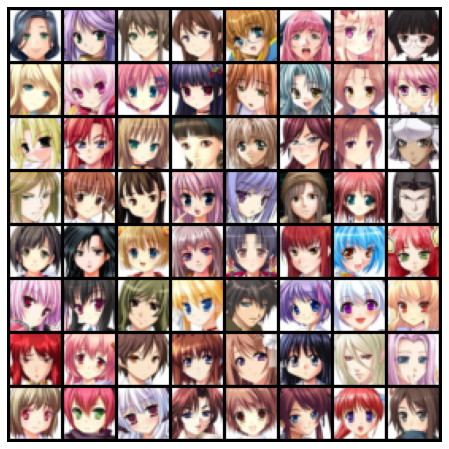

In [8]:
dataiter = iter(image_loader)
images, labels = next(dataiter)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(np.transpose(tv.utils.make_grid(images.to(device)[:64], padding=2, normalize=True).cpu(), (1,2,0)))

# Generator

- In GANs, the generator is a neural network that ussualy takes noise as input and generates a synthetic data.
- This generated data could be numerical data, images, auido, or any other data.
- According to problem, the generators' achitecture differs from one to another.
- If our problem is image generation, the generator will generate an image. So it probably needs to use ConvTranspose2D layers.
- Or if we want to generate numerical data, the generator will generate a vector. So it might use Dense layers.

- There is no specific architecture for the generator.

- The generators input could be noise or some other data. (noise = random vector)

- We want to generate images so we defined the generator suitable for image generation.

### ConvTranspose2D layers
- ConvTranspose2D layers are used to upsample the data.
- ConvTranspose2D layers simply reverse the process of Conv2D layers(almost).
- For pytorch, ConvTranspose2D layers arguments are:
    - in_channels: the number of input channels.
    - out_channels: the number of output channels.
    - kernel_size: the size of the convolution kernel.
    - stride: the stride of the convolution.
    - padding: the padding of the convolution.

- We use Tanh activation function as final activation function.
- That because the output values of the generator needs to be between -1 and 1.

![Generator Loss](./img_src/gen_loss.png) Generator Loss

In [9]:
# Generator network
class Generator(nn.Module):
    def __init__(self) -> None:
        super(Generator, self).__init__()
        
        self.main = nn.Sequential(
            # input is Z, going into a deconvolution
            nn.ConvTranspose2d(noise_layer_size, 32 * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(32 * 4),
            nn.ReLU(True),
            # state size. (32*4) x 4 x 4
            nn.ConvTranspose2d(32 * 4, 32 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32 * 2),
            nn.ReLU(True),
            # state size. (32*2) x 8 x 8
            nn.ConvTranspose2d(32 * 2, 32 * 1, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            # state size. (32) x 16 x 16
            nn.ConvTranspose2d(32, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (3) x 32 x 32
        )
    
    def forward(self, input):
        return self.main(input)

# Testing the generator

In [10]:
gen_test = Generator()

In [11]:
with torch.no_grad():
    test_noise = torch.randn((1, noise_layer_size, 1, 1))
    test_gen_out = gen_test(test_noise)
    print(test_gen_out.shape)

torch.Size([1, 3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


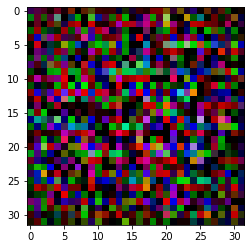

In [12]:
plt.imshow(np.transpose(test_gen_out.cpu().numpy()[0], (1,2,0)))

In [13]:
print(gen_test)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


# Discriminator

- The discriminator is a neural network that ussualy takes the data as input and outputs a value between 0 and 1.
- Goal of the discriminator is to detect the fake(generated) data and real data.

- Also, there is no specific architecture for the discriminator.

- We train generator using the discriminator.

- Again according to our problem, we defined the discriminator suitable for image classification.

![Discriminator Loss](./img_src/disc_loss.png) Discriminator Loss

In [14]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 2, 2),
            nn.LeakyReLU(0.2,),
            nn.Dropout(0.3,),
            nn.Conv2d(64, 128, 2, 2),
            nn.LeakyReLU(0.2,),
            nn.Dropout(0.3,),
            nn.Conv2d(128, 256, 2, 2),
            nn.LeakyReLU(0.2,),
            nn.Dropout(0.3,),
            nn.Flatten(start_dim=1),
            nn.Linear(4096, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

# Discriminator test

In [15]:
disc_test = Discriminator()

In [16]:
images.shape

torch.Size([256, 3, 32, 32])

In [17]:
with torch.no_grad():
    test_disc_out = disc_test(images)
    print(test_disc_out.shape)

torch.Size([256, 1])


In [18]:
print(disc_test)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(2, 2), stride=(2, 2))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2))
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Conv2d(128, 256, kernel_size=(2, 2), stride=(2, 2))
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=4096, out_features=1, bias=True)
    (11): Sigmoid()
  )
)


# Preparing for training

In [19]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)

- As loss function, we use binary cross entropy loss function (Because the output of the discriminator is a probability between 1 and 0).
- Other loss functions could be used.

In [20]:
loss_f = nn.BCELoss() # Binary cross entropy loss | Output of our discriminator is a probability between 0 and 1 so we use BCELoss
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

# Training

In [23]:
G_losses = []
D_losses = []

iters = 0

# Fixed noise vector to see progress of generator
seed = torch.randn((16,noise_layer_size, 1, 1),device=device)

for epoch in range(num_epoch):
    for i, (images, labels) in enumerate(image_loader):
        # Carry images to device
        images = images.to(device)

        # We will use these two to compute the loss
        ones = torch.ones((batch_size, 1), device=device)
        zeros = torch.zeros((batch_size, 1), device=device)

        #####Discriminator#####

        discriminator.zero_grad()

        real_out = discriminator(images) # Result of the discriminator on the real images

        noise = torch.randn((batch_size, noise_layer_size, 1, 1), device=device) # Noise vector to pass to the generator
        generated_images = generator(noise) # Generated images from the noise vector

        fake_out = discriminator(generated_images.detach()) # Result of the discriminator on the generated images
        
        # Compute the loss for real images
        lossD_R = loss_f(real_out, ones)
        lossD_R.backward()
        outD_R = real_out.mean().item()
        
        # Compute the loss for generated images
        lossD_G = loss_f(fake_out, zeros)
        lossD_G.backward()
        outD_G = fake_out.mean().item()
        
        # Total loss
        lossD = lossD_R + lossD_G # We sum two losses for the discriminator
        disc_optimizer.step()

        #####Generator#####

        generator.zero_grad()
        ones = torch.ones((batch_size, 1), device=device) # We use this to compute the loss
        fake_out = discriminator(generated_images) # Result of the discriminator on the generated images
        
        # Compute the loss for generated images
        lossG = loss_f(fake_out, ones)
        lossG.backward()

        outG = fake_out.mean().item()
        gen_optimizer.step()

        # Print the progress of our training
        if i % 100 == 0:
            print(f"{epoch}/{num_epoch} LossD: {lossD:.3f}, LossG: {lossG:.3f}, outD_R: {outD_R:.3f}, outD_G: {outD_G:.3f}, outG: {outG:.3f}")
        # Save the losses for plotting
        G_losses.append(lossG)
        D_losses.append(lossD)

        # Save the generated images
        if (iters % 250 == 0) or ((epoch == num_epoch-1) and (i == len(image_loader)-1)):
            with torch.no_grad():
                fake = generator(seed).detach().cpu()
            tv.utils.save_image(tv.utils.make_grid(fake, padding=2, normalize=True), fp=f"./images/{iters}.png")
        iters += 1

0/100 LossD: 1.387, LossG: 0.693, outD_R: 0.507, outD_G: 0.507, outG: 0.500
0/100 LossD: 0.111, LossG: 3.744, outD_R: 0.970, outD_G: 0.063, outG: 0.031
0/100 LossD: 0.559, LossG: 4.537, outD_R: 0.852, outD_G: 0.143, outG: 0.023
1/100 LossD: 0.253, LossG: 4.254, outD_R: 0.914, outD_G: 0.065, outG: 0.027
1/100 LossD: 0.433, LossG: 3.002, outD_R: 0.849, outD_G: 0.161, outG: 0.080
1/100 LossD: 0.246, LossG: 3.618, outD_R: 0.904, outD_G: 0.099, outG: 0.056
2/100 LossD: 0.214, LossG: 4.506, outD_R: 0.926, outD_G: 0.084, outG: 0.049
2/100 LossD: 1.183, LossG: 2.204, outD_R: 0.628, outD_G: 0.315, outG: 0.213
2/100 LossD: 0.331, LossG: 3.355, outD_R: 0.887, outD_G: 0.136, outG: 0.080
3/100 LossD: 0.428, LossG: 3.241, outD_R: 0.842, outD_G: 0.150, outG: 0.070
3/100 LossD: 0.989, LossG: 2.811, outD_R: 0.759, outD_G: 0.301, outG: 0.120
3/100 LossD: 0.425, LossG: 3.024, outD_R: 0.874, outD_G: 0.154, outG: 0.099
4/100 LossD: 0.471, LossG: 2.983, outD_R: 0.839, outD_G: 0.150, outG: 0.119
4/100 LossD:

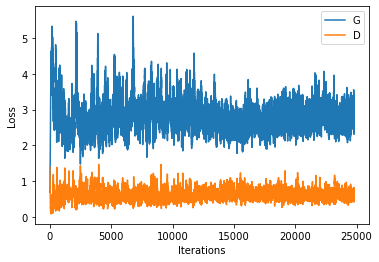

In [24]:
_G_losses = torch.tensor(G_losses)
_D_losses = torch.tensor(D_losses)

plt.plot(_G_losses, label="G")
plt.plot(_D_losses, label="D")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

In [25]:
# Save the model
torch.save(generator.state_dict(), "./generator.pt")
torch.save(discriminator.state_dict(), "./discriminator.pt")